# Modelling optimization

- Create new baseline regression models using the preprocessed training dataset and different regression algorithms (regression trees, SVR, k-NN Regression..)
- Evaluate baseline models with your preprocessed validation dataset *
- Optimize your baseline models / create further model versions
    - Hyper-parameter Tuning: Change the hyper-parameters of your algorithms (e.g. „kernel“ in case of
    SVR)
    - Feature Selection: Remove features, which are not helpful for your model
- Evaluate each model version with your preprocessed validation dataset * and store evaluation results in an evaluation data frame
- Finally, check your best model, applying it to the preprocessed test dataset*.
- Also analyze feature importance within your best model **
- Within the validation and test dataset, you are not allowed to remove examples / rows or
change label values
- Visualize your evaluation results
- Document and present the learnings from the coding for this task
- Keep grading criteria for this task in mind!

\* based on accuracies and f1 measure

** based on p-values or other appropriate measures

# Import libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import time

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

# Load data

In [2]:
# Load training and testing datasets with ; separator
train_set = pd.read_csv('BikeRentalDaily_train_prepared.csv', sep=',')
val_set = pd.read_csv('BikeRentalDaily_val_prepared.csv', sep=',')
test_set = pd.read_csv('BikeRentalDaily_test_prepared.csv', sep=',')

print("Training Data Shape:", train_set.shape)
print("Validation Data Shape:", val_set.shape)
print("Testing Data Shape:", test_set.shape)

train_set.head()

Training Data Shape: (480, 21)
Validation Data Shape: (120, 21)
Testing Data Shape: (132, 21)


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,...,leaflets,price reduction,cnt,day_of_month,season_sin,season_cos,mnth_sin,mnth_cos,weekday_sin,weekday_cos
0,207,3.0,0,7,0,2,1,1,30.8667,44.981347,...,692,0,4590,26,-1.000000e+00,-1.836970e-16,-0.500000,-8.660254e-01,0.974928,-0.222521
1,71,1.0,0,3,0,6,0,1,13.1667,51.832120,...,580,0,2132,12,1.000000e+00,6.123234e-17,1.000000,6.123234e-17,-0.781831,0.623490
2,60,1.0,0,3,0,2,1,1,10.6667,44.237895,...,971,0,1851,1,1.000000e+00,6.123234e-17,1.000000,6.123234e-17,0.974928,-0.222521
3,477,2.0,1,4,0,6,0,1,22.8000,63.090839,...,524,0,6624,21,1.224647e-16,-1.000000e+00,0.866025,-5.000000e-01,-0.781831,0.623490
4,44,1.0,0,2,0,6,0,1,12.6609,34.346143,...,686,1,1589,13,1.000000e+00,6.123234e-17,0.866025,5.000000e-01,-0.781831,0.623490


In [3]:
# Separate Features (X) and Target (y) for all three sets
# Training Set (used to fit the model)
X_train = train_set.drop(columns=['cnt'])
y_train = train_set['cnt']

# Validation Set (used to evaluate performance during training)
X_val = val_set.drop(columns=['cnt'])
y_val = val_set['cnt']

# Test Set
X_test = test_set.drop(columns=['cnt'])
y_test = test_set['cnt']

# Auxiliar functions

In [4]:
# Initialize our master list
model_performance_list = []

def record_performance(model_name, model, X_train, y_train, X_val, y_val, train_time, notes="Default", step="Baseline"):
    """
    Records results. train_time must be passed as a parameter 
    representing the duration of the training task.
    """
    # Generate predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    # Calculate metrics
    perf = {
        "Model": model_name,
        "Step": step,
        "Train MAE": mean_absolute_error(y_train, train_preds),
        "Val MAE": mean_absolute_error(y_val, val_preds),
        "Train R2": r2_score(y_train, train_preds),
        "Val R2": r2_score(y_val, val_preds),
        "Train Time (s)": round(train_time, 4), # Recorded from the parameter
        "Notes": notes
    }
    
    model_performance_list.append(perf)
    return pd.DataFrame(model_performance_list)

In [5]:
def get_performance_summary(results_list=None, sort_by="Val MAE", ascending=True):
    """
    Returns a formatted DataFrame. 
    'results_list': defaults to the global list if None.
    'sort_by': the column name to sort by.
    'ascending': True for MAE (lower is better), False for R2 (higher is better).
    """
    if results_list is None:
        results_list = model_performance_list
        
    df = pd.DataFrame(results_list)
    
    # Check if the requested column exists to avoid errors
    if sort_by in df.columns:
        return df.sort_values(by=sort_by, ascending=ascending)
    else:
        print(f"Warning: {sort_by} not found. Returning unsorted.")
        return df

In [6]:
def show_summary_graph(df, steps_to_show=None):
    """
    Generates performance graphs. 
    'steps_to_show' can be a string or a list of strings (e.g., ["Baseline", "Optimized"]).
    If None, it shows all steps.
    """
    # 1. Filter the dataframe if specific steps are requested
    df_to_plot = df.copy()
    if steps_to_show is not None:
        # If a single string is passed, convert it to a list
        if isinstance(steps_to_show, str):
            steps_to_show = [steps_to_show]
        # Filter rows where 'Step' is in the provided list
        df_to_plot = df_to_plot[df_to_plot['Step'].isin(steps_to_show)]

    if df_to_plot.empty:
        print("No data found for the selected steps.")
        return

    # 2. Prepare Labels and Sort
    # We combine Model and Step for a clear Y-axis label
    df_to_plot['Label'] = df_to_plot['Model'] + " (" + df_to_plot['Step'] + ")"
    
    # Sorting by Val MAE usually makes the comparison more intuitive
    df_sorted = df_to_plot.sort_values('Model', ascending=True)

    # --- PLOT 1: Mean Absolute Error (MAE) ---
    plt.figure(figsize=(12, 10))
    mae_df = df_sorted.melt(id_vars='Label', value_vars=['Train MAE', 'Val MAE'], 
                            var_name='Dataset', value_name='MAE')

    sns.barplot(data=mae_df, y='Label', x='MAE', hue='Dataset', palette='viridis')
    plt.title('Mean Absolute Error (MAE): Lower is Better', fontsize=14, fontweight='bold')
    plt.xlabel('MAE (Units: Bike Count)', fontsize=12)
    plt.ylabel('Model Configuration', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- PLOT 2: R-Squared (R2) ---
    plt.figure(figsize=(12, 10))
    r2_df = df_sorted.melt(id_vars='Label', value_vars=['Train R2', 'Val R2'], 
                           var_name='Dataset', value_name='R2')

    sns.barplot(data=r2_df, y='Label', x='R2', hue='Dataset', palette='magma')
    plt.title('R2-Score (R2): Higher is Better', fontsize=14, fontweight='bold')
    plt.xlabel('R2 Score (Variance Explained)', fontsize=12)
    plt.ylabel('Model Configuration', fontsize=12)
    plt.xlim(-1, 1) 
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Baseline models

In [7]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("SVR", SVR()),
    ("k-NN", KNeighborsRegressor()),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    # ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42, verbose=0)),
]

In [8]:
for name, model_obj in models:
    print(f"Processing: {name}...")
    
    # Training
    start = time.time()
    model_obj.fit(X_train, y_train)
    end = time.time()
    duration = end - start
    
    # Record results
    record_performance(
        model_name=name, 
        model=model_obj, 
        X_train=X_train, 
        y_train=y_train, 
        X_val=X_val, 
        y_val=y_val, 
        train_time=duration, 
        notes="Default parameters, no scaling",
        step="Baseline",
    )

Processing: Linear Regression...
Processing: Decision Tree...
Processing: SVR...
Processing: k-NN...
Processing: Random Forest...
Processing: XGBoost...
Processing: LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 480, number of used features: 19
[LightGBM] [Info] Start training from score 4664.922917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

## Show baseline results

In [9]:
# View results
results = get_performance_summary(sort_by="Val MAE")
display(results)

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"


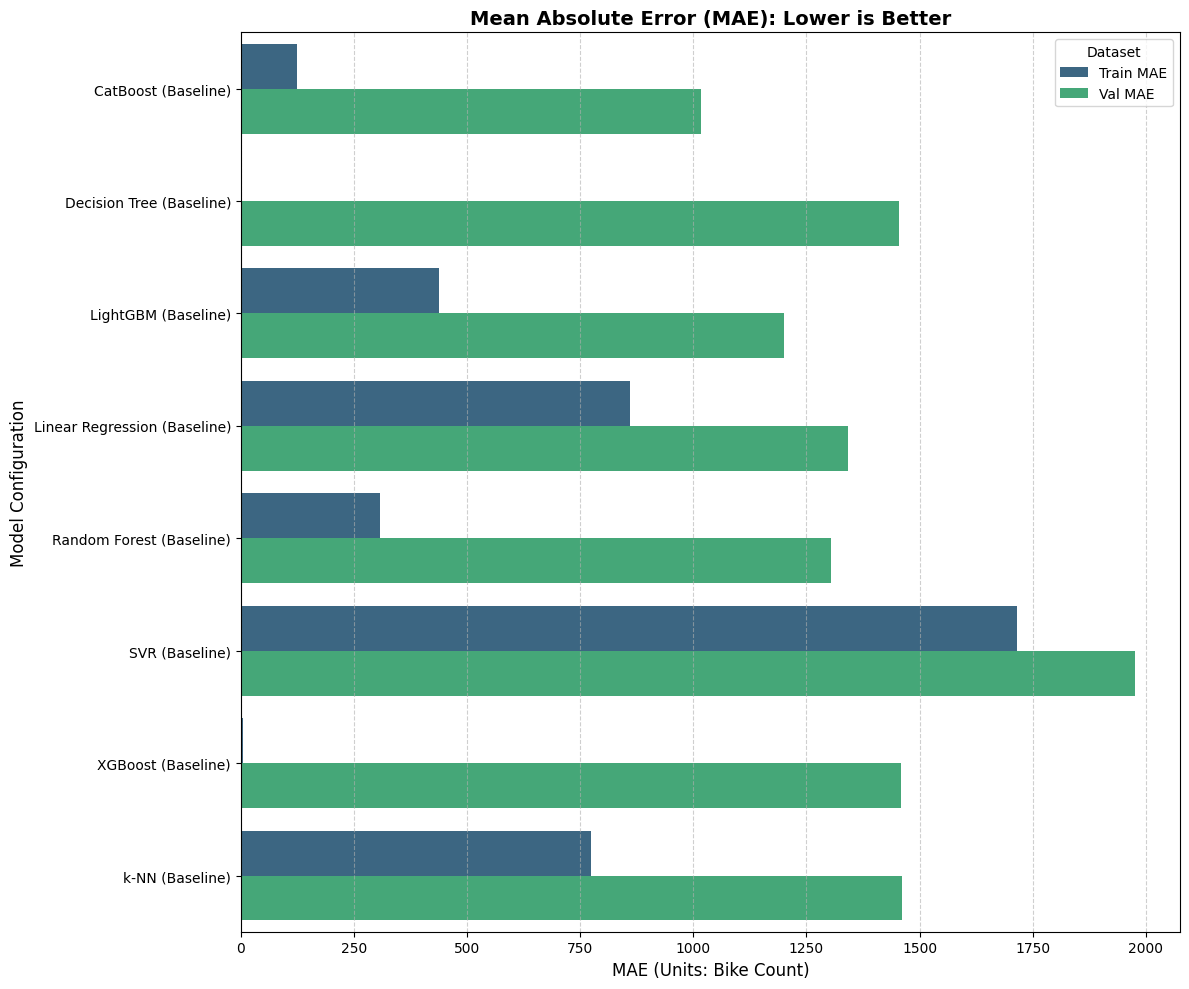

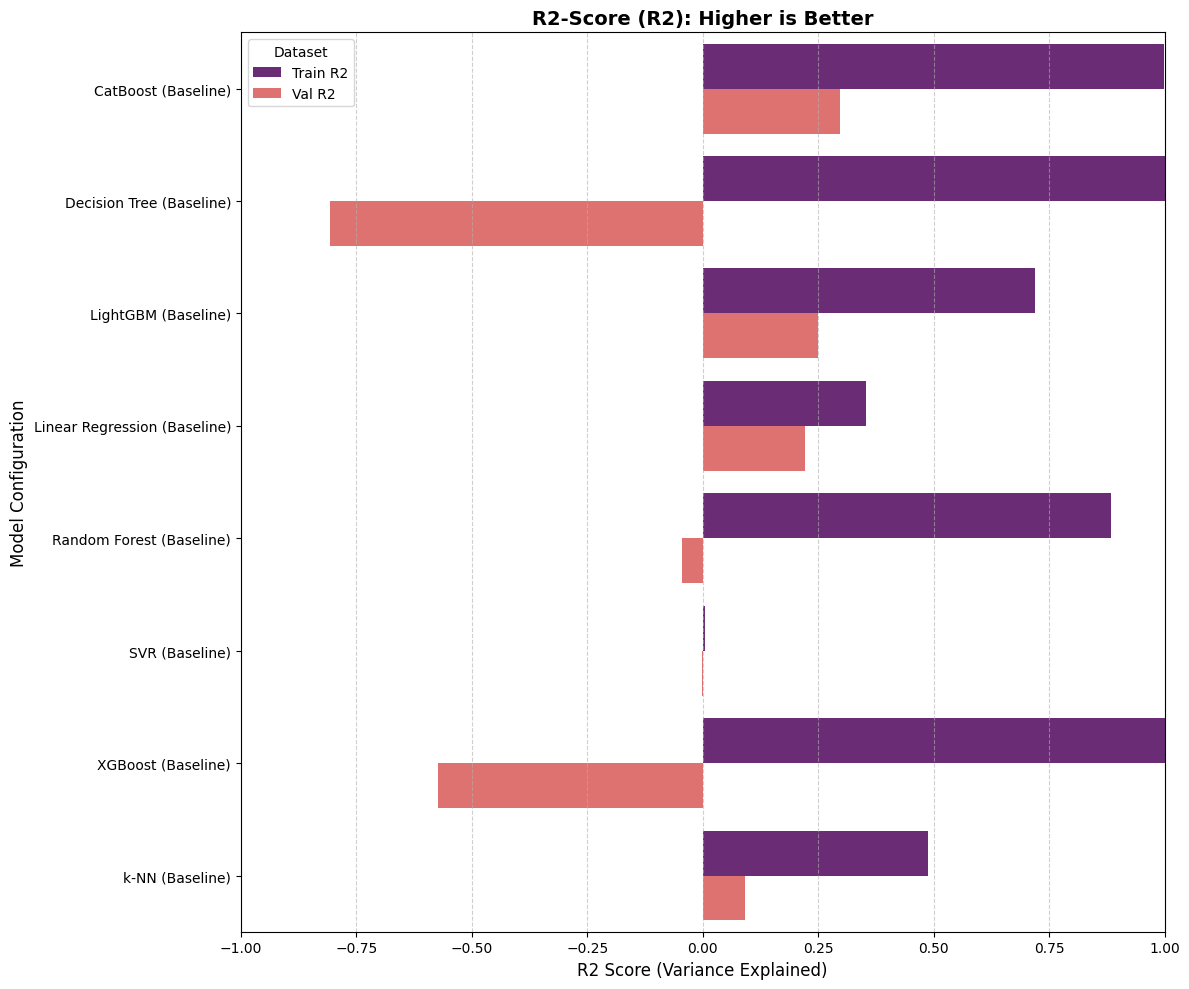

In [10]:
# Show results in graph
show_summary_graph(results)


## Partial conclusions from baseline results

- Decision Tree and XGBoost are highly overfitted models. Low train MAE and high validation MAE with negative validation R2-scores.
- All the models suffer of overfitting.
- Catboost has the best performance in terms of MAE and R2-score. However the results are still really bad.

Some explanations can be related with:
- The algorithms were trained without constraints like max_depth in the case of Decision Trees, so they try to fit every example in the training set.
- The features aren't standardized and that might affect models that rely on distances (like SVR and k-NN).

# Baseline models basic optimization

## Constraint trees depths

### Decission Tree

In [11]:
# Define max_depth and min_samples_leaf
pruned_dt = DecisionTreeRegressor(
    max_depth=10, 
    min_samples_leaf=10, 
    random_state=42
)

# Time the training
start = time.time()
pruned_dt.fit(X_train, y_train)
duration = time.time() - start

# Record the new improved result
record_performance(
    "Decision Tree", 
    pruned_dt, 
    X_train, y_train, 
    X_val, y_val, 
    train_time=duration, 
    notes="Stabilized: Pruned",
    step="Stabilized",
)

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned


### Random Forest


In [12]:
# Limit depth and stablish min samples per leaf for generalization
pruned_rf = RandomForestRegressor(
    max_depth=12,          # Stop trees from getting too specific
    min_samples_leaf=5,    # Each leaf must represent at least 5 bike rentals
    random_state=42
)

start = time.time()
pruned_rf.fit(X_train, y_train)
duration = time.time() - start

record_performance("Random Forest", pruned_rf, X_train, y_train, X_val, y_val, duration, notes="Stabilized: Pruned", step="Stabilized")

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


### XGBoost

In [13]:
# Stabilization for XGBoost
pruned_xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,    # Slow down the learning (default is 0.3)
    max_depth=5,           # Shorter trees are less likely to overfit
    subsample=0.8,         # Use only 80% of data per tree (adds randomness)
    colsample_bytree=0.8,  # Use only 80% of features per tree
    random_state=42
)

start = time.time()
pruned_xgb.fit(X_train, y_train)
duration = time.time() - start

record_performance("XGBoost", pruned_xgb, X_train, y_train, X_val, y_val, duration, notes="Stabilized: Pruned and randomized", step="Stabilized")

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


### LightGBM

In [14]:
improved_lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,        # Main parameter for LightGBM complexity
    max_depth=7,          # Limit depth to prevent overfitting
    random_state=42,
    verbosity=-1
)

start = time.time()
improved_lgbm.fit(X_train, y_train)
duration = time.time() - start

record_performance("LightGBM", improved_lgbm, X_train, y_train, X_val, y_val, duration, notes="Stabilized: Throttled", step="Stabilized")

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


### CatBoost

In [15]:
improved_cat = CatBoostRegressor(
    n_estimators=500,
    learning_rate=0.05,
    depth=8,
    random_state=42,
    verbose=0
)

start = time.time()
improved_cat.fit(X_train, y_train)
duration = time.time() - start

record_performance("CatBoost", improved_cat, X_train, y_train, X_val, y_val, duration, notes="Stabilized: Regularized", step="Stabilized")

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## Standarization for distance based methods

In [16]:
# Initialize the Scaler
std_scaler = StandardScaler()

# Fit and Transform Training data
X_train_scaled = std_scaler.fit_transform(X_train)

# Transform Validation data
X_val_scaled = std_scaler.transform(X_val)

### Linear Regression

In [17]:
# We use the SCALED data here so we can compare feature importance later
improved_lr = LinearRegression()

start = time.time()
improved_lr.fit(X_train_scaled, y_train)
duration = time.time() - start

record_performance("Linear Regression", improved_lr, X_train_scaled, y_train, X_val_scaled, y_val, duration, notes="Stabilized: Scaled", step="Stabilized")

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


### k-NN

In [18]:
# Increasing neighbors usually helps smooth out predictions
improved_knn = KNeighborsRegressor(n_neighbors=7, weights='uniform')

start = time.time()
improved_knn.fit(X_train_scaled, y_train) # Use SCALED data
duration = time.time() - start

record_performance("k-NN", improved_knn, X_train_scaled, y_train, X_val_scaled, y_val, duration, notes="Stabilized: Scaled + k=7", step="Stabilized")

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


### Support Vector Regressor

In [19]:
# SVR is extremely sensitive to scaling
improved_svr = SVR(C=1000, epsilon=10)

start = time.time()
improved_svr.fit(X_train_scaled, y_train) # Use SCALED data
duration = time.time() - start

record_performance("SVR", improved_svr, X_train_scaled, y_train, X_val_scaled, y_val, duration, notes="Stabilized: Scaled + C=1000", step="Stabilized")

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


# Show results

In [20]:
# View results
results = get_performance_summary(sort_by="Model")
display(results)

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
12,CatBoost,Stabilized,109.159958,1000.621020,0.998198,0.314068,1.3254,Stabilized: Regularized
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
11,LightGBM,Stabilized,368.857442,1357.610999,0.883220,0.174405,0.0804,Stabilized: Throttled
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
13,Linear Regression,Stabilized,859.281939,1341.873287,0.353380,0.221641,0.0030,Stabilized: Scaled
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


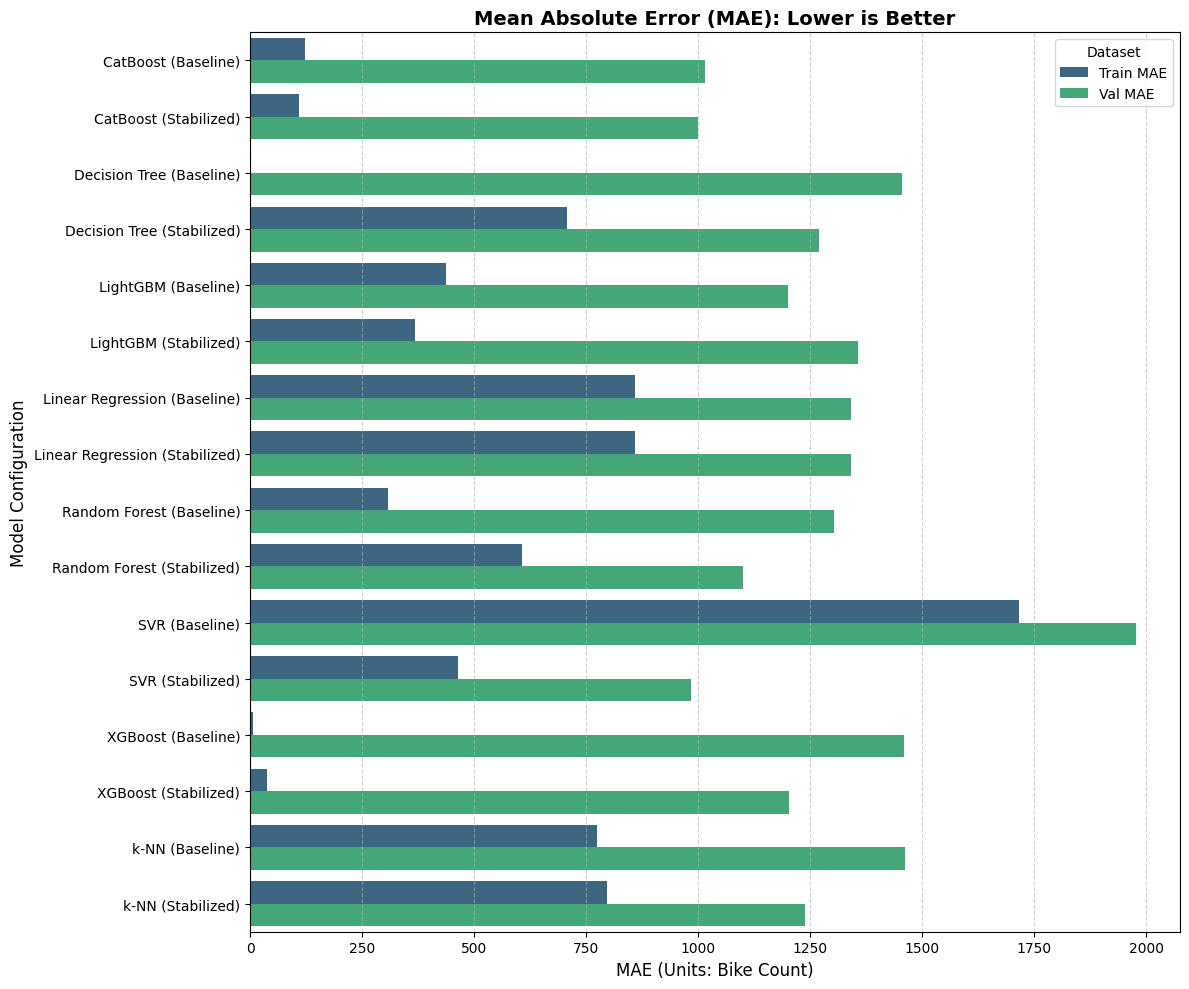

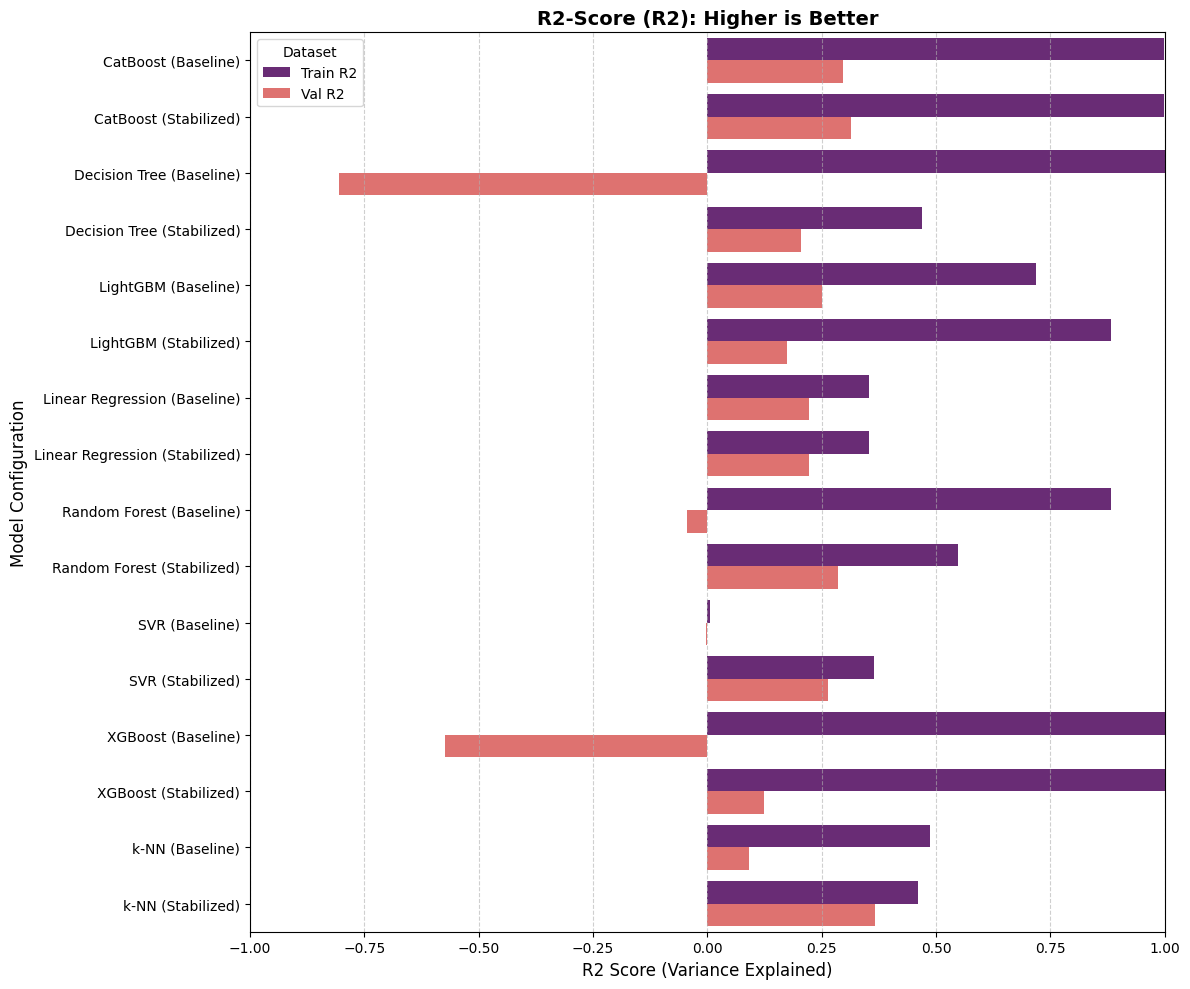

In [21]:
# Show results in graph
show_summary_graph(results)

## Partial conclusions from basic optimization

- SVR from the worst result became in the best one in terms of MAE. The scaling and some basic parameter optimization produced a great change in the performance. The differences of MAE in training and validation were also reduced probing best generalization
- XGBoost show really low MAE in training, showing a high overfitting
- Random Forest ist the most robust model with the lest difference in the MAE duriong training and during validation

# Feature selection using correlation and colinearity

### Based on correlation

In [22]:
#caluclate correlation of numeric features with label
target_corr = X_train.corrwith(y_train).abs().sort_values(ascending=False)
target_corr

instant            0.416765
temp               0.384511
yr                 0.370203
season_sin         0.345675
mnth_cos           0.280188
mnth_sin           0.241165
season             0.232309
weathersit         0.210954
mnth               0.194216
windspeed          0.152504
weekday            0.089427
hum                0.083648
weekday_sin        0.082733
leaflets           0.073172
season_cos         0.061271
holiday            0.057434
workingday         0.056789
price reduction    0.037477
weekday_cos        0.031024
day_of_month       0.022134
dtype: float64

In [23]:
# Filter out low values
low_relevance = target_corr[target_corr < 0.05]

# 2. Delete them from your Training and Validation sets
low_relevance_features = low_relevance.index.tolist()
X_train_reduced = X_train.drop(columns=low_relevance_features)
X_val_reduced = X_val.drop(columns=low_relevance_features)

print(f"Removed low-relevance features: {low_relevance_features}")

Removed low-relevance features: ['price reduction', 'weekday_cos', 'day_of_month']


### Detect Collinearity

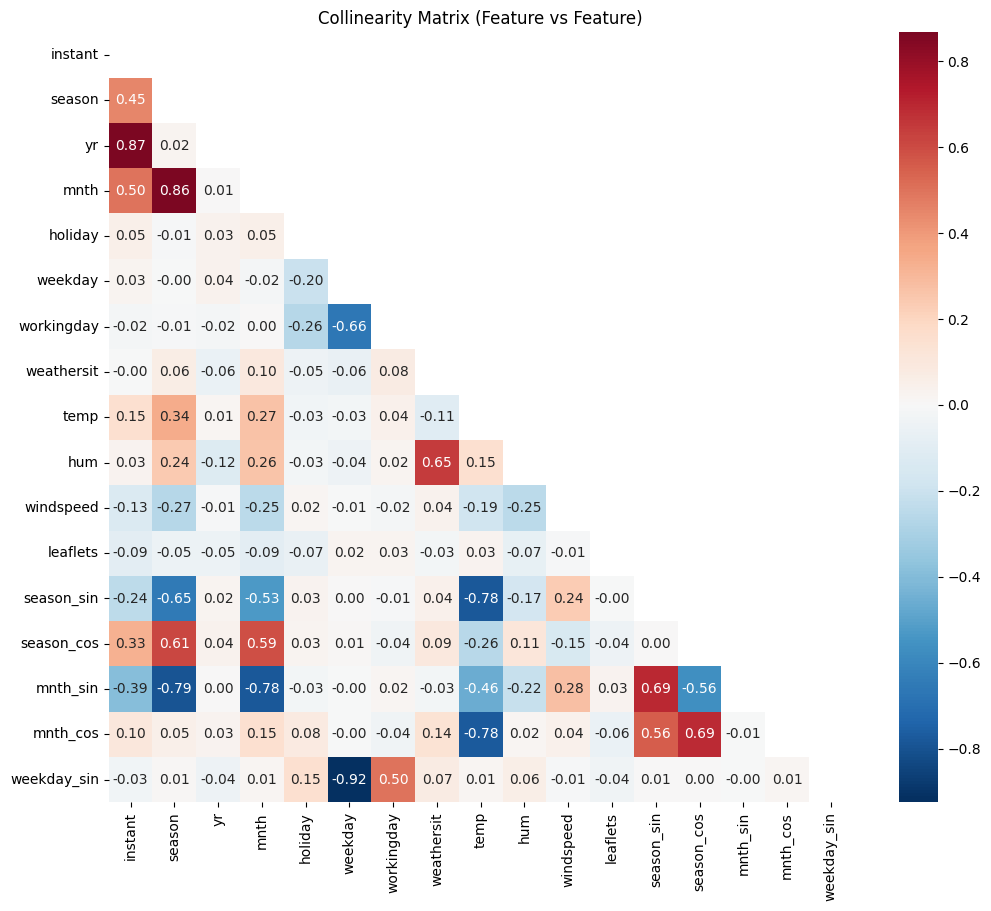

In [24]:
# 1. Visualization: Heatmap of the Feature-to-Feature relationships
plt.figure(figsize=(12, 10))
# We use the actual X_train_reduced features here
feature_corr = X_train_reduced.corr()
mask = np.triu(np.ones_like(feature_corr, dtype=bool)) # Hide the duplicate half

sns.heatmap(feature_corr, mask=mask, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
plt.title("Collinearity Matrix (Feature vs Feature)")
plt.show()

In [25]:
threshold = 0.5

#apply a mask to highlight colinearity values > 0.5
feature_corr_strong = (abs(feature_corr) > threshold)*1
# Displaying correlations as a heatmap / correlation matrix
feature_corr_strong.style.background_gradient(cmap ='coolwarm')

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,leaflets,season_sin,season_cos,mnth_sin,mnth_cos,weekday_sin
instant,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
season,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0
yr,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mnth,1,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0
holiday,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
weekday,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
workingday,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
weathersit,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
temp,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
hum,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0


## Variance Inflation Factor

In [26]:
#calculate multicollinearity of numeric features
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(df):
    vif = pd.DataFrame()
    vif["features"] = df.columns
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif.sort_values(by="VIF Factor", ascending=False)
    
calc_vif(X_train_reduced)

,features,VIF Factor
0,instant,2233.921901
2,yr,859.215441
3,mnth,626.608801
5,weekday,46.290029
8,temp,43.364949
1,season,43.355255
9,hum,24.302555
11,leaflets,19.377737
7,weathersit,15.473798
15,mnth_cos,7.973985


In [27]:
X_vif_recursive = X_train_reduced.copy()
vif_dropped_list = []
max_vif_threshold = 10.0

while True:
    # Get current scores
    vif_df = calc_vif(X_vif_recursive)
    
    # Find the highest VIF value and the feature name
    current_max_vif = vif_df['VIF Factor'].max()
    feature_to_remove = vif_df.sort_values('VIF Factor', ascending=False)['features'].iloc[0]
    
    if current_max_vif > max_vif_threshold:
        print(f"Removing '{feature_to_remove}' with VIF: {current_max_vif:.2f}")
        
        # 3. Drop from the working dataframe
        X_vif_recursive = X_vif_recursive.drop(columns=[feature_to_remove])
        vif_dropped_list.append(feature_to_remove)
    else:
        # Success! All features are under the threshold
        print("--- All features are now under the VIF threshold ---")
        break

# Final display
print(f"Total dropped by VIF: {vif_dropped_list}")
final_vif_report = calc_vif(X_vif_recursive)
print(final_vif_report)

Removing 'instant' with VIF: 2233.92
Removing 'weekday' with VIF: 45.19
Removing 'season' with VIF: 39.69
Removing 'temp' with VIF: 33.39
Removing 'hum' with VIF: 19.21
Removing 'leaflets' with VIF: 11.60
--- All features are now under the VIF threshold ---
Total dropped by VIF: ['instant', 'weekday', 'season', 'temp', 'hum', 'leaflets']
       features  VIF Factor
1          mnth    9.103210
4    weathersit    6.575710
5     windspeed    5.682431
8      mnth_sin    5.347981
6    season_sin    5.079491
7    season_cos    4.849014
9      mnth_cos    4.627068
3    workingday    4.387647
0            yr    1.946235
10  weekday_sin    1.464135
2       holiday    1.253670


In [28]:
# Sync the validation set to match the VIF-cleansed training set
X_train_reduced = X_train_reduced.drop(columns=vif_dropped_list)
X_val_reduced = X_val_reduced.drop(columns=vif_dropped_list)

print(X_train_reduced.shape)
print(X_val_reduced.shape)

(480, 11)
(120, 11)


# Baseline after feature selection

## Decision Tree

In [29]:
# Define max_depth and min_samples_leaf
pruned_reduced_dt = DecisionTreeRegressor(
    max_depth=10, 
    min_samples_leaf=10, 
    random_state=42
)

# Time the training
start = time.time()
pruned_dt.fit(X_train_reduced, y_train)
duration = time.time() - start

# Record the new improved result
record_performance(
    "Decision Tree", 
    pruned_dt, 
    X_train_reduced, y_train, 
    X_val_reduced, y_val, 
    train_time=duration, 
    notes="Stabilized: Pruned and reduced features",
    step="Reduced Features",
)

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## Random Forest

In [30]:
# Limit depth and stablish min samples per leaf for generalization
pruned_reduced_rf = RandomForestRegressor(
    max_depth=12,          # Stop trees from getting too specific
    min_samples_leaf=5,    # Each leaf must represent at least 5 bike rentals
    random_state=42
)

start = time.time()
pruned_reduced_rf.fit(X_train_reduced, y_train)
duration = time.time() - start

record_performance("Random Forest", pruned_reduced_rf, X_train_reduced, y_train, X_val_reduced, y_val, duration, notes="Stabilized: Pruned + Reduced features", step="Reduced Features")

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## CatBoost

In [31]:
improved_reduced_cat = CatBoostRegressor(
    n_estimators=500,
    learning_rate=0.05,
    depth=8,
    random_state=42,
    verbose=0
)

start = time.time()
improved_reduced_cat.fit(X_train_reduced, y_train)
duration = time.time() - start

record_performance("CatBoost", improved_reduced_cat, X_train_reduced, y_train, X_val_reduced, y_val, duration, notes="Stabilized: Regularized + Reduced features", step="Reduced Features")

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## Support Vector Regression

In [32]:
# Initialize the Scaler
std_scaler = StandardScaler()

# Fit and Transform Training data
X_train_scaled_reduced = std_scaler.fit_transform(X_train_reduced)

# Transform Validation data
X_val_scaled_reduced = std_scaler.transform(X_val_reduced)

In [33]:
# SVR is extremely sensitive to scaling
improved_reduced_svr = SVR(C=1000, epsilon=10)

start = time.time()
improved_reduced_svr.fit(X_train_scaled_reduced, y_train) # Use SCALED data
duration = time.time() - start

record_performance("SVR", improved_reduced_svr, X_train_scaled_reduced, y_train, X_val_scaled_reduced, y_val, duration, notes="Stabilized: Scaled + C=1000 + Reduced features", step="Reduced Features")

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## Linear Regression

In [34]:
# We use the SCALED data here so we can compare feature importance later
improved_reduced_lr = LinearRegression()

start = time.time()
improved_reduced_lr.fit(X_train_scaled_reduced, y_train)
duration = time.time() - start

record_performance("Linear Regression", improved_reduced_lr, X_train_scaled_reduced, y_train, X_val_scaled_reduced, y_val, duration, notes="Stabilized: Scaled + Reduced features", step="Reduced Features")

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## K-NN

In [35]:
# Increasing neighbors usually helps smooth out predictions
improved_reduced_knn = KNeighborsRegressor(n_neighbors=7, weights='uniform')

start = time.time()
improved_reduced_knn.fit(X_train_scaled_reduced, y_train) # Use SCALED data
duration = time.time() - start

record_performance("k-NN", improved_reduced_knn, X_train_scaled_reduced, y_train, X_val_scaled_reduced, y_val, duration, notes="Stabilized: Scaled + k=7 + reduced features", step="Reduced Features",)

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## Show results

In [36]:
# View results
results = get_performance_summary(sort_by="Model")
display(results)

,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
12,CatBoost,Stabilized,109.159958,1000.621020,0.998198,0.314068,1.3254,Stabilized: Regularized
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
18,CatBoost,Reduced Features,274.623357,1266.219826,0.988730,0.260171,1.2328,Stabilized: Regularized + Reduced features
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
16,Decision Tree,Reduced Features,853.659379,1295.660322,0.379912,0.294862,0.0030,Stabilized: Pruned and reduced features
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
11,LightGBM,Stabilized,368.857442,1357.610999,0.883220,0.174405,0.0804,Stabilized: Throttled
20,Linear Regression,Reduced Features,902.768848,1416.311151,0.330132,0.183316,0.0010,Stabilized: Scaled + Reduced features
13,Linear Regression,Stabilized,859.281939,1341.873287,0.353380,0.221641,0.0030,Stabilized: Scaled


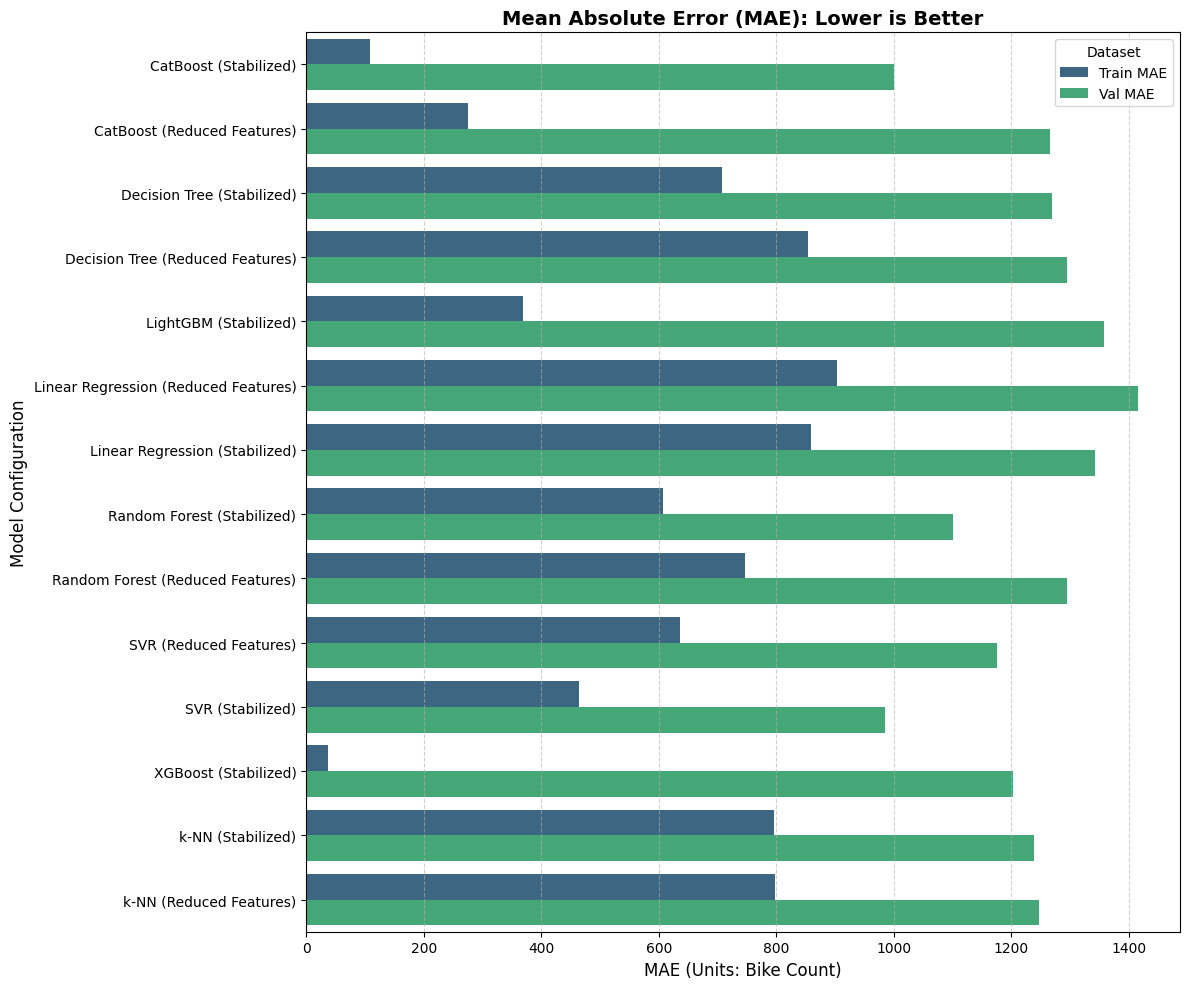

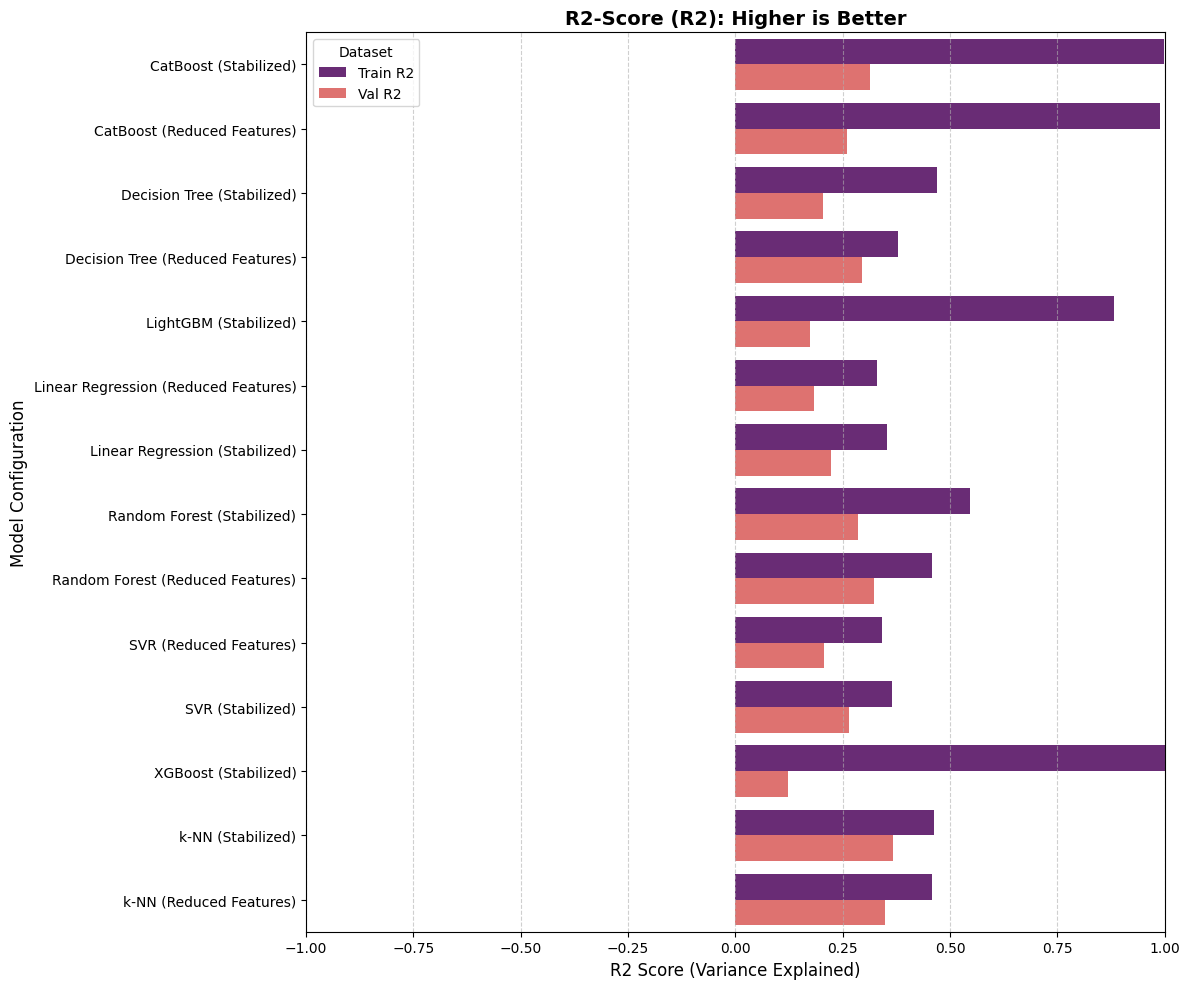

In [37]:
# Show results in graph
show_summary_graph(results, steps_to_show=["Stabilized", "Reduced Features"])

### Partial conclusions after feature selection

- After feature selection most all the models performance dropped compared to the models before feature selection.
- Even when the methods of feature selection detect attributes with no so hight relevance indepentdently. Together they may iclude some information that is usefull for the models.

# Model Hyperparameter Optimization

## Linear Regression

In [ ]:
# Define the parameter grid for Linear Regression
param_grid_lr = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Initialize GridSearchCV
# Using 5-fold cross-validation and R-squared as the scoring metric
grid_lr = GridSearchCV(LinearRegression(), param_grid_lr, cv=5, scoring='neg_mean_absolute_error')

# Training
start = time.time()
# Train on the TRAINING set
grid_lr.fit(X_train_scaled, y_train)
end = time.time()
duration = end - start

# Get the best estimator
best_lr_model = grid_lr.best_estimator_
print("Best Parameters:", grid_lr.best_params_)

# Record and display results
record_performance("Linear Regression (Optimized)", best_lr_model, X_train_scaled, y_train, X_val_scaled, y_val, duration, notes=f"GridSearch: {grid_lr.best_params_}", step="Optimized")

Best Parameters: {'fit_intercept': True, 'positive': False}


,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## Regression Tree

In [39]:
# Define the parameter grid for the Decision Tree
param_grid_dt = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize GridSearchCV
# Scoring by R-squared is common for regression
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_dt, cv=5, scoring='neg_mean_absolute_error')

# Training
start = time.time()
# Train on the TRAINING set
grid_dt.fit(X_train, y_train)
end = time.time()
duration = end - start

# Get the best parameters and the best model
print("Best Parameters:", grid_dt.best_params_)
best_dt_model = grid_dt.best_estimator_

# Record and display the results
record_performance("Decision Tree (Optimized)", best_dt_model, X_train, y_train, X_val, y_val, duration, notes=f"GridSearch: {grid_dt.best_params_}", step="Optimized")

Best Parameters: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## Support Vector Regressor

In [40]:
# Define the parameter grid for SVR
# SVR is sensitive to the scale of data and its hyperparameters.
param_grid_svr = {
    'C': [0.1, 1, 10, 100, 1000, 4000, 6000, 8000],     # Regularization parameter
    'epsilon': [0.1, 1, 10, 40, 80, 100, 150],          # Specifies the epsilon-tube within which no penalty is associated
    'kernel': ['linear', 'rbf'],                        # Trying both linear and non-linear patterns
    'gamma': ['scale', 'auto']                          # Kernel coefficient for 'rbf' ['scale', 'auto', 0.01, 0.1, 1]   
}

# Initialize GridSearchCV
# Using n_jobs=-1 will use all your CPU cores to speed up the search
grid_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Training
start = time.time()
# Train on the TRAINING set
grid_svr.fit(X_train_scaled, y_train)
end = time.time()
duration = end - start

# Get the best parameters and the best model
print("Best Parameters:", grid_svr.best_params_)
best_svr_model = grid_svr.best_estimator_

# Record and display the results
record_performance("SVR (Optimized)", best_svr_model, X_train_scaled, y_train, X_val_scaled, y_val, duration, notes=f"GridSearch: {grid_lr.best_params_}", step="Optimized")

Best Parameters: {'C': 4000, 'epsilon': 80, 'gamma': 'scale', 'kernel': 'rbf'}


,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## KNN

In [41]:
# Define the parameter grid for k-NN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],  # 'distance' weight points by the inverse of their distance
    'p': [1, 2]                          # 1 = Manhattan distance, 2 = Euclidean distance
}

# Initialize GridSearchCV
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Training
start = time.time()
# Train on the TRAINING set
grid_knn.fit(X_train_scaled, y_train)
end = time.time()
duration = end - start

# Get the best parameters and the best model
print("Best Parameters:", grid_knn.best_params_)
best_knn_model = grid_knn.best_estimator_

# Record and display the results
record_performance("KNN (Optimized)", best_knn_model, X_train_scaled, y_train, X_val_scaled, y_val, duration, notes=f"GridSearch: {grid_knn.best_params_}", step="Optimized")

Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## Random Forest

In [42]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 300, 400, 500],        # Number of trees in the forest
    'max_depth': [None, 10, 12, 20],        # Depth of each tree
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4, 5],       # Minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider at each split
}

# Initialize GridSearchCV
# Using n_jobs=-1 is highly recommended as Random Forest is computationally expensive
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Training
start = time.time()
# Train on the TRAINING set
grid_rf.fit(X_train, y_train)
end = time.time()
duration = end - start

# Get the best parameters and the best model
print("Best Parameters:", grid_rf.best_params_)
best_rf_model = grid_rf.best_estimator_

# Record and display the results
record_performance("Random Forest (Optimized)", best_rf_model, X_train, y_train, X_val, y_val, duration, notes=f"GridSearch: {grid_rf.best_params_}", step="Optimized")

Best Parameters: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}


,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## XGBoost

In [44]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [500, 1000, 2000],           # Number of boosting rounds
    'learning_rate': [0.05, 0.1],   # Step size shrinkage
    'max_depth': [5, 7],               # Maximum depth of a tree
    'subsample': [0.7, 0.8, 1.0],         # Fraction of samples used per tree
    'colsample_bytree': [0.7, 0.8, 1.0]   # Fraction of features used per tree
}

# Initialize GridSearchCV
# n_jobs=-1 helps speed up the process
grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Training
start = time.time()
# Train on the TRAINING set
grid_xgb.fit(X_train, y_train)
end = time.time()
duration = end - start

# Get the best parameters and the best model
print("Best Parameters:", grid_xgb.best_params_)
best_xgb_model = grid_xgb.best_estimator_

# Record and display the results
record_performance("XGBoost (Optimized)", best_xgb_model, X_train, y_train, X_val, y_val, duration, notes=f"GridSearch: {grid_xgb.best_params_}", step="Optimized")

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.7}


,Model,Step,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression,Baseline,859.281939,1341.873287,0.353380,0.221641,0.0020,"Default parameters, no scaling"
1,Decision Tree,Baseline,0.000000,1454.975000,1.000000,-0.805838,0.0050,"Default parameters, no scaling"
2,SVR,Baseline,1716.059980,1976.854782,0.004826,-0.002225,0.0090,"Default parameters, no scaling"
3,k-NN,Baseline,773.838333,1461.456667,0.487123,0.091054,0.0010,"Default parameters, no scaling"
4,Random Forest,Baseline,307.633542,1304.098167,0.883017,-0.044472,0.2858,"Default parameters, no scaling"
5,XGBoost,Baseline,5.945889,1459.346924,0.999993,-0.573390,0.0712,"Default parameters, no scaling"
6,LightGBM,Baseline,437.941413,1200.831472,0.718793,0.250635,0.0388,"Default parameters, no scaling"
7,CatBoost,Baseline,123.638364,1016.564289,0.997751,0.296183,1.2939,"Default parameters, no scaling"
8,Decision Tree,Stabilized,707.592570,1270.124265,0.470122,0.204066,0.0040,Stabilized: Pruned
9,Random Forest,Stabilized,608.068712,1100.454092,0.547521,0.285295,0.2035,Stabilized: Pruned


## LightGBM

In [5]:
# Define the parameter grid for LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],           # Main parameter to control complexity
    'max_depth': [-1, 5, 7, 10],            # -1 means no limit
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Initialize GridSearchCV
# Using verbosity=-1 in the model helps keep the logs clean during the search
grid_lgbm = GridSearchCV(
    LGBMRegressor(random_state=42, verbosity=-1), 
    param_grid_lgbm, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1
)

# Training
start = time.time()
# Train on the TRAINING set
grid_lgbm.fit(X_train, y_train)
end = time.time()
duration = end - start

# Get the best parameters and the best model
print("Best Parameters:", grid_lgbm.best_params_)
best_lgbm_model = grid_lgbm.best_estimator_

# Record and display the results
record_performance("LightGBM (Optimized)", best_lgbm_model, X_train, y_train, X_val, y_val, duration, notes=f"GridSearch: {grid_lgbm.best_params_}", step="Optimized")

NameError: name 'X_train' is not defined

## CatBoost

In [ ]:
# Define the parameter grid for LightGBM
param_grid_cat = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 5, 10],
    'iterations': [1000, 1500]
}

# Initialize GridSearchCV
# Using verbosity=-1 in the model helps keep the logs clean during the search
grid_cat = GridSearchCV(
    CatBoostRegressor(random_state=42), 
    param_grid_cat, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    n_jobs=-1
)

# Training
start = time.time()
# Train on the TRAINING set
grid_cat.fit(X_train, y_train)
end = time.time()
duration = end - start

# Get the best parameters and the best model
print("Best Parameters:", grid_cat.best_params_)
best_cat_model = grid_cat.best_estimator_

# Record and display the results
record_performance("CatBoost (Optimized)", best_cat_model, X_train, y_train, X_val, y_val, duration, notes=f"GridSearch: {grid_cat.best_params_}", step="Optimized")

KeyboardInterrupt: 

# Show Optimized Results

In [45]:
# View results
results = get_performance_summary(sort_by="Model")
display(results)

,Model,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
18,CatBoost,274.623357,1266.219826,0.988730,0.260171,1.2400,Stabilized: Regularized + Reduced features
12,CatBoost,109.159958,1000.621020,0.998198,0.314068,1.4257,Stabilized: Regularized
7,CatBoost (baseline),123.638364,1016.564289,0.997751,0.296183,1.2567,Baseline
8,Decision Tree,707.592570,1270.124265,0.470122,0.204066,0.0060,Stabilized: Pruned
16,Decision Tree,853.659379,1295.660322,0.379912,0.294862,0.0030,Stabilized: Pruned and reduced features
23,Decision Tree (Optimized),716.713436,1152.685411,0.521473,0.250802,2.4948,"GridSearch: {'max_depth': 5, 'max_features': N..."
1,Decision Tree (baseline),0.000000,1454.975000,1.000000,-0.805838,0.0106,Baseline
25,KNN (Optimized),0.000000,1008.578950,1.000000,0.537839,0.3007,"GridSearch: {'n_neighbors': 3, 'p': 1, 'weight..."
11,LightGBM,368.857442,1357.610999,0.883220,0.174405,0.0836,Stabilized: Throttled
28,LightGBM (Optimized),520.251346,1123.581035,0.596108,0.288561,76.7462,"GridSearch: {'colsample_bytree': 1.0, 'learnin..."


## Save results to csv

In [45]:

results.to_csv('BikeRentalDaily_val_results-OK.csv', index=False)


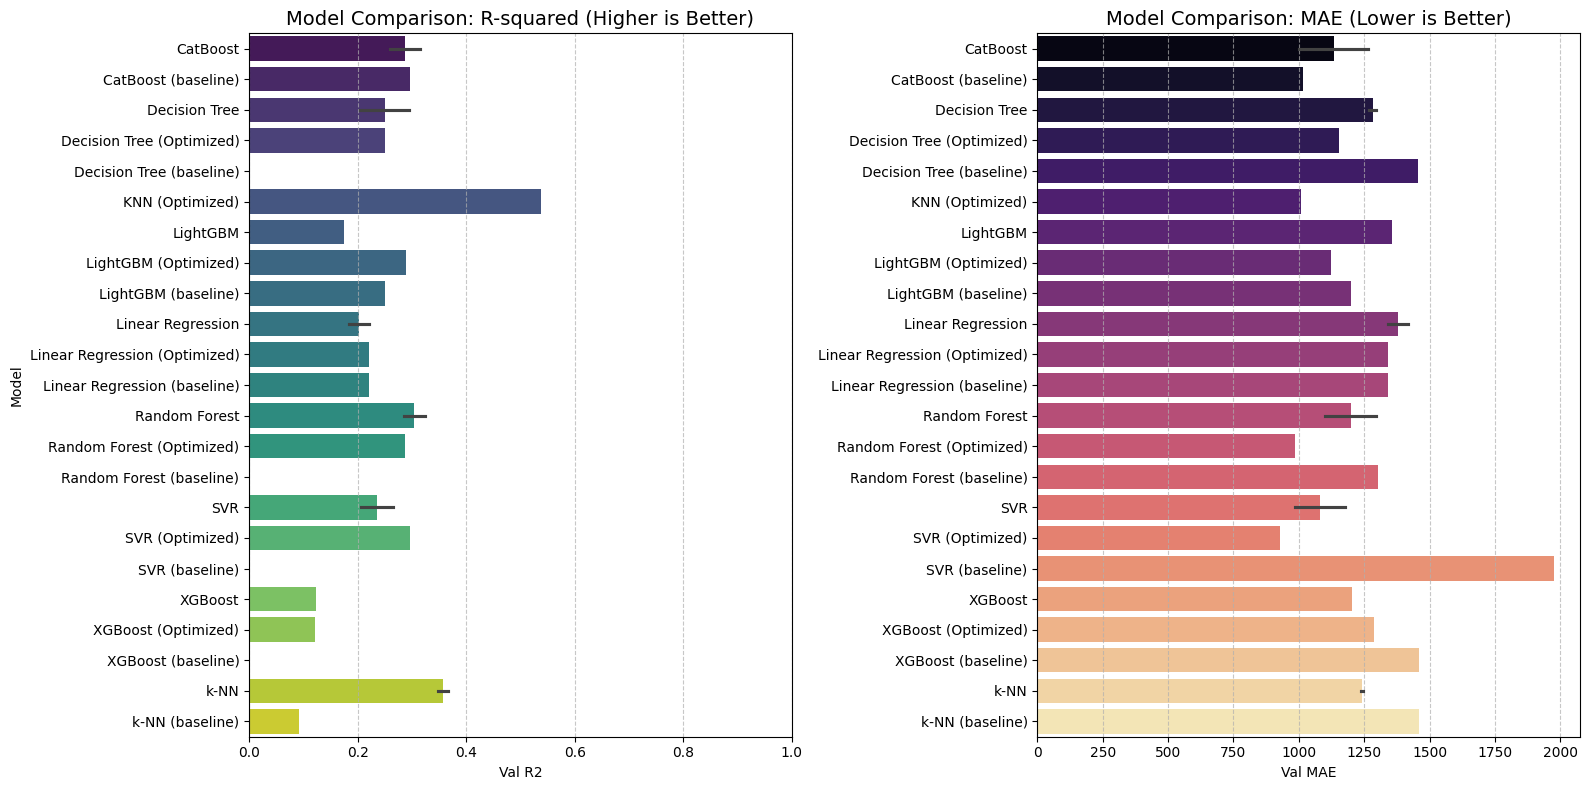

In [50]:
df_viz = results.copy()
# Set up the plotting area (2 subplots: R-squared and MAE)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# --- Plot 1: R-squared (Higher is Better) ---
sns.barplot(data=df_viz, x="Val R2", y="Model", ax=axes[0], hue="Model", palette="viridis", legend=False)
axes[0].set_title("Model Comparison: R-squared (Higher is Better)", fontsize=14)
axes[0].set_xlim(0, 1.0) 
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
# --- Plot 2: MAE (Lower is Better) ---
sns.barplot(data=df_viz, x="Val MAE", y="Model", ax=axes[1], hue="Model", palette="magma", legend=False)
axes[1].set_title("Model Comparison: MAE (Lower is Better)", fontsize=14)
axes[1].set_ylabel("") 
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Hyperparameter optimizattion after feature selection

## Support Vector Regression 

In [47]:
# Define the parameter grid for SVR
# SVR is sensitive to the scale of data and its hyperparameters.
param_grid_svr = {
    'C': [0.1, 1, 10, 100, 1000, 4000, 6000, 8000],     # Regularization parameter
    'epsilon': [0.1, 1, 10, 40, 80, 100, 150],          # Specifies the epsilon-tube within which no penalty is associated
    'kernel': ['linear', 'rbf'],                        # Trying both linear and non-linear patterns
    'gamma': ['scale', 'auto']                          # Kernel coefficient for 'rbf' ['scale', 'auto', 0.01, 0.1, 1]   
}

# Initialize GridSearchCV
# Using n_jobs=-1 will use all your CPU cores to speed up the search
grid_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Training
start = time.time()
# Train on the TRAINING set
grid_svr.fit(X_train_scaled_reduced, y_train)
end = time.time()
duration = end - start

# Get the best parameters and the best model
print("Best Parameters:", grid_svr.best_params_)
best_svr_model = grid_svr.best_estimator_

# Record and display the results
record_performance("SVR (Optimized)", best_svr_model, X_train_scaled_reduced, y_train, X_val_scaled_reduced, y_val, duration, notes=f"Feature selection + GridSearch: {grid_lr.best_params_}")

Best Parameters: {'C': 1000, 'epsilon': 10, 'gamma': 'scale', 'kernel': 'rbf'}


,Model,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression (baseline),859.281939,1341.873287,0.353380,0.221641,0.0050,Baseline
1,Decision Tree (baseline),0.000000,1454.975000,1.000000,-0.805838,0.0106,Baseline
2,SVR (baseline),1716.059980,1976.854782,0.004826,-0.002225,0.0302,Baseline
3,k-NN (baseline),773.838333,1461.456667,0.487123,0.091054,0.0020,Baseline
4,Random Forest (baseline),307.633542,1304.098167,0.883017,-0.044472,0.2879,Baseline
5,XGBoost (baseline),5.945889,1459.346924,0.999993,-0.573390,0.0705,Baseline
6,LightGBM (baseline),437.941413,1200.831472,0.718793,0.250635,0.0255,Baseline
7,CatBoost (baseline),123.638364,1016.564289,0.997751,0.296183,1.2567,Baseline
8,Decision Tree,707.592570,1270.124265,0.470122,0.204066,0.0060,Stabilized: Pruned
9,Random Forest,608.068712,1100.454092,0.547521,0.285295,0.1990,Stabilized: Pruned


## Random Forest

In [48]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 300, 400, 500],        # Number of trees in the forest
    'max_depth': [None, 10, 12, 20],        # Depth of each tree
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4, 5],       # Minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider at each split
}

# Initialize GridSearchCV
# Using n_jobs=-1 is highly recommended as Random Forest is computationally expensive
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Training
start = time.time()
# Train on the TRAINING set
grid_rf.fit(X_train_reduced, y_train)
end = time.time()
duration = end - start

# Get the best parameters and the best model
print("Best Parameters:", grid_rf.best_params_)
best_rf_model = grid_rf.best_estimator_

# Record and display the results
record_performance("Random Forest (Optimized)", best_rf_model, X_train_reduced, y_train, X_val_reduced, y_val, duration, notes=f"Feature selection +GridSearch: {grid_rf.best_params_}")

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}


,Model,Train MAE,Val MAE,Train R2,Val R2,Train Time (s),Notes
0,Linear Regression (baseline),859.281939,1341.873287,0.353380,0.221641,0.0050,Baseline
1,Decision Tree (baseline),0.000000,1454.975000,1.000000,-0.805838,0.0106,Baseline
2,SVR (baseline),1716.059980,1976.854782,0.004826,-0.002225,0.0302,Baseline
3,k-NN (baseline),773.838333,1461.456667,0.487123,0.091054,0.0020,Baseline
4,Random Forest (baseline),307.633542,1304.098167,0.883017,-0.044472,0.2879,Baseline
5,XGBoost (baseline),5.945889,1459.346924,0.999993,-0.573390,0.0705,Baseline
6,LightGBM (baseline),437.941413,1200.831472,0.718793,0.250635,0.0255,Baseline
7,CatBoost (baseline),123.638364,1016.564289,0.997751,0.296183,1.2567,Baseline
8,Decision Tree,707.592570,1270.124265,0.470122,0.204066,0.0060,Stabilized: Pruned
9,Random Forest,608.068712,1100.454092,0.547521,0.285295,0.1990,Stabilized: Pruned


# Show Feature Importance

In [ ]:
best_model_name = df_results.sort_values(by="R-squared", ascending=False).iloc[1]['Model']
print(f"Your best performing model is: {best_model_name}")

# --- SELECT YOUR BEST MODEL HERE ---
# Example: If XGBoost was best, use grid_xgb.best_estimator_ or best_xgb_model
winner_model = best_svr_model 

Your best performing model is: SVR (Optimized)


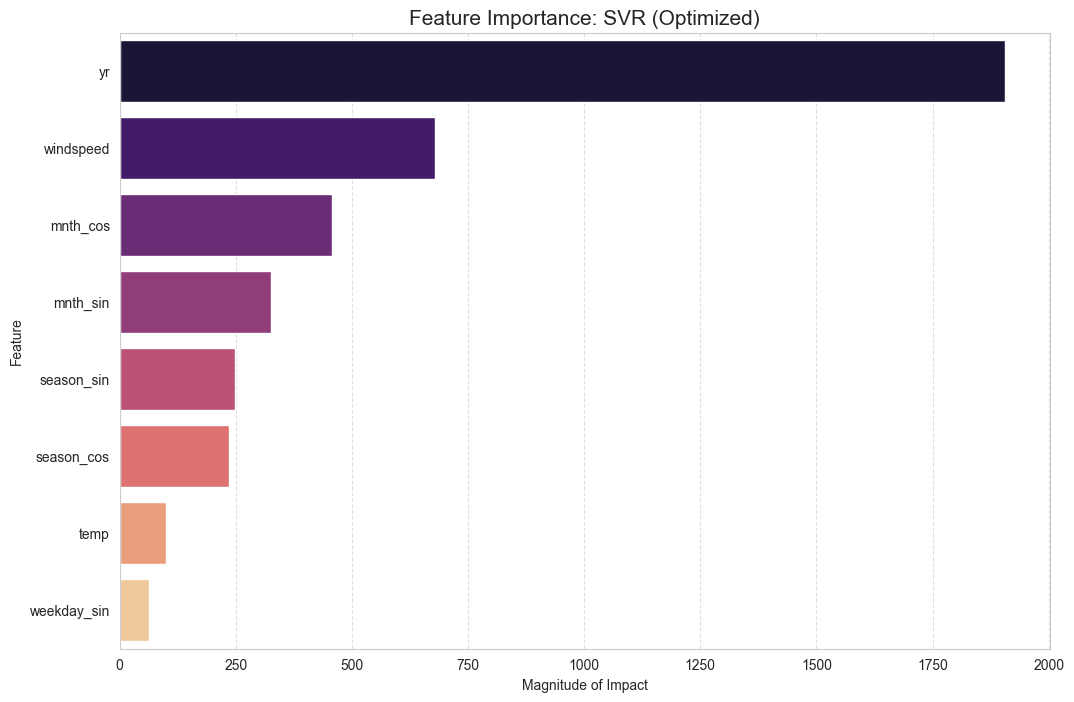

In [ ]:
feature_names = X_train.columns

# 1. If it's a Tree-Based Model (Random Forest, XGBoost, LightGBM, Decision Tree)
if hasattr(winner_model, 'feature_importances_'):
    importances = winner_model.feature_importances_
    df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# 2. If it's a Linear Model (Linear Regression, SVR with linear kernel)
elif hasattr(winner_model, 'coef_'):
    # Note: Coefficients need to be absolute to show magnitude of impact
    importances = np.abs(winner_model.coef_.flatten())
    df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# 3. If it's a model without direct attributes (like SVR RBF or KNN)
else:
    print("Calculating Permutation Importance (this may take a moment)...")
    result = permutation_importance(winner_model, X_val, y_val, n_repeats=10, random_state=42)
    df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': result.importances_mean})

# --- Visualization ---
df_imp = df_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_imp, x='Importance', y='Feature', hue='Feature', palette='magma', legend=False)
plt.title(f"Feature Importance: {best_model_name}", fontsize=15)
plt.xlabel("Magnitude of Impact")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# Test Best Models

In [ ]:
# Re-initialize an empty list to store model performance
model_performance_list = []

## Test Decission Tree (Baseline)

In [ ]:
y_test_pred_dt = dt_model.predict(x_test_orig)

print("--- Test Model Performance ---")
print(f"R-squared (Test): {r2_score(y_test, y_test_pred_dt):.4f}")
print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred_dt)):.2f}")

# 6. Record and display the results
df_results = record_performance("Decision Tree (Baseline) - Test", y_test, y_test_pred_dt)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- cnt


## Test SVR (optimized)

In [ ]:
y_test_pred_svr = best_svr_model.predict(X_test)

print("--- Test Model Performance ---")
print(f"R-squared (Test): {r2_score(y_test, y_test_pred_svr):.4f}")
print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred_svr)):.2f}")


# 6. Record and display the results
df_results = record_performance("Random Forest (Optimized) - Test", y_test, y_test_pred_svr)

--- Test Model Performance ---
R-squared (Test): 0.3852
RMSE (Test): 2435.99


## Test Random Forest (optimized)

In [ ]:
y_test_pred_rf = best_rf_model.predict(X_test)

print("--- Test Model Performance ---")
print(f"R-squared (Test): {r2_score(y_test, y_test_pred_rf):.4f}")
print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred_rf)):.2f}")

# 6. Record and display the results
df_results = record_performance("Random Forest (Optimized) - Test", y_test, y_test_pred_rf)

--- Test Model Performance ---
R-squared (Test): 0.4777
RMSE (Test): 2245.29


## Test Linear Regression (Baseline)

In [ ]:
y_test_pred_lr = lr_model.predict(X_test)

print("--- Test Model Performance ---")
print(f"R-squared (Test): {r2_score(y_test, y_test_pred_lr):.4f}")
print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred_lr)):.2f}")

# 6. Record and display the results
df_results = record_performance("Linear Regression (Baseline) - Test", y_test, y_test_pred_lr)

--- Test Model Performance ---
R-squared (Test): 0.3875
RMSE (Test): 2431.54


## Test Linear Regression (Optimized)

In [ ]:
y_test_pred_lr_opt = best_lr_model.predict(X_test)

print("--- Test Model Performance ---")
print(f"R-squared (Test): {r2_score(y_test, y_test_pred_lr_opt):.4f}")
print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred_lr_opt)):.2f}")

# 6. Record and display the results
df_results = record_performance("Linear Regression (Optimized) - Test", y_test, y_test_pred_lr_opt)

--- Test Model Performance ---
R-squared (Test): 0.3889
RMSE (Test): 2428.77


## Test XGBoost (Optimized)

In [ ]:
y_test_pred_xgb_opt = best_xgb_model.predict(X_test)

print("--- Test Model Performance ---")
print(f"R-squared (Test): {r2_score(y_test, y_test_pred_xgb_opt):.4f}")
print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred_xgb_opt)):.2f}")

# 6. Record and display the results
df_results = record_performance("XGBoost (Optimized) - Test", y_test, y_test_pred_xgb_opt)

--- Test Model Performance ---
R-squared (Test): 0.4009
RMSE (Test): 2404.75


# Show Test Model Performance

In [ ]:
df_results = df_results.sort_values('Model').reset_index(drop=True)
df_results

,Model,R-squared,RMSE
0,Decision Tree (Baseline) - Test,-1.531849,4943.609275
1,Linear Regression (Baseline) - Test,0.387492,2431.538015
2,Linear Regression (Optimized) - Test,0.388886,2428.769424
3,Random Forest (Optimized) - Test,0.385248,2435.988375
4,Random Forest (Optimized) - Test,0.477729,2245.294476
5,XGBoost (Optimized) - Test,0.400915,2404.747700


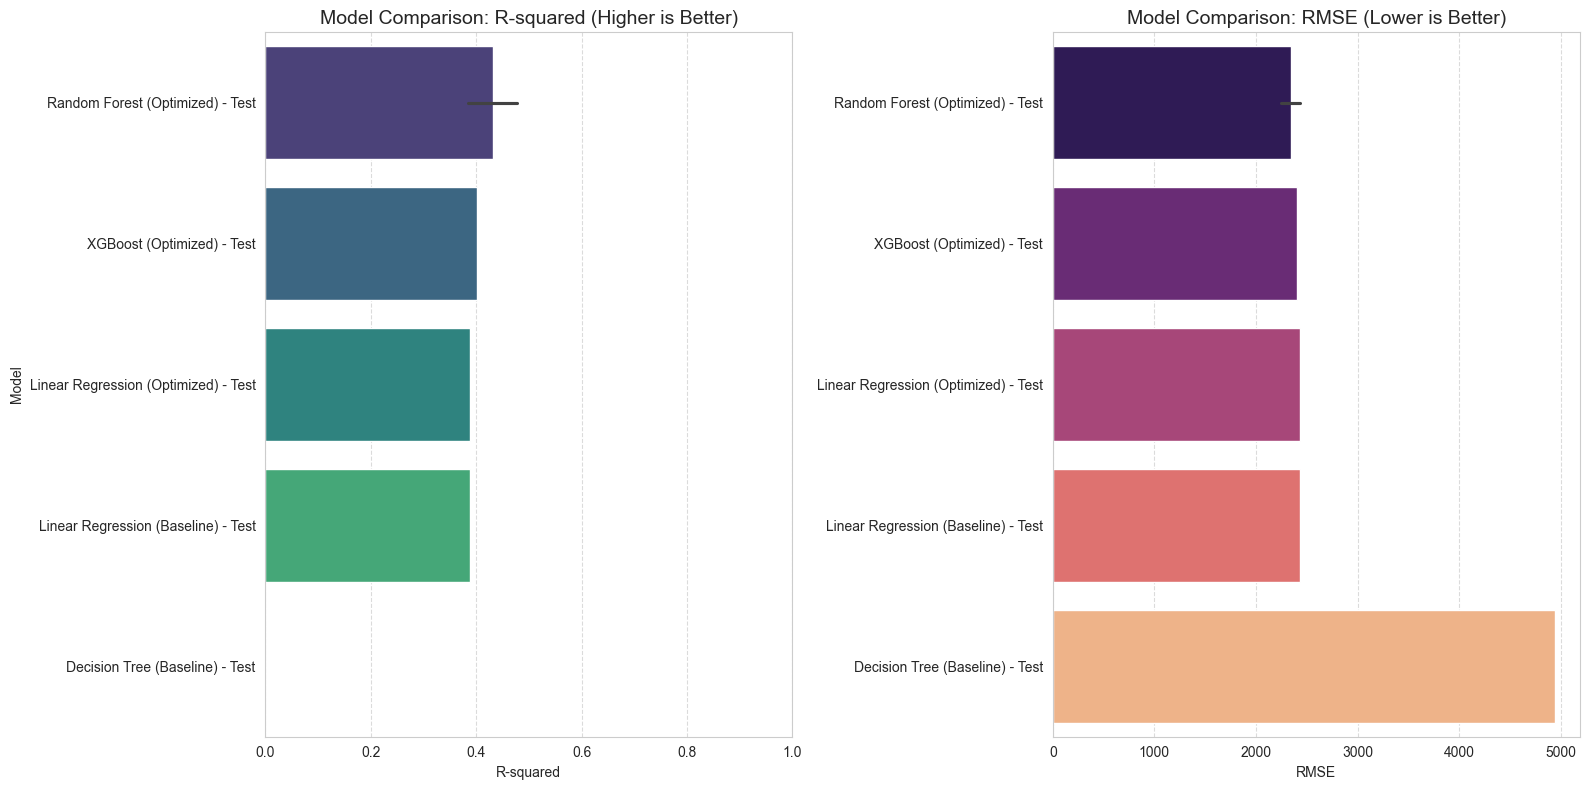

In [ ]:
# 1. Sort results by R-squared for better visualization
df_viz = df_results.sort_values(by="R-squared", ascending=False)
# 2. Set up the plotting area (2 subplots: R-squared and RMSE)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# --- Plot 1: R-squared (Higher is Better) ---
# Added hue="Model" and legend=False to resolve the warning
sns.barplot(data=df_viz, x="R-squared", y="Model", ax=axes[0], hue="Model", palette="viridis", legend=False)
axes[0].set_title("Model Comparison: R-squared (Higher is Better)", fontsize=14)
axes[0].set_xlim(0, 1.0) 
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
# --- Plot 2: RMSE (Lower is Better) ---
sns.barplot(data=df_viz, x="RMSE", y="Model", ax=axes[1], hue="Model", palette="magma", legend=False)
axes[1].set_title("Model Comparison: RMSE (Lower is Better)", fontsize=14)
axes[1].set_ylabel("") 
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

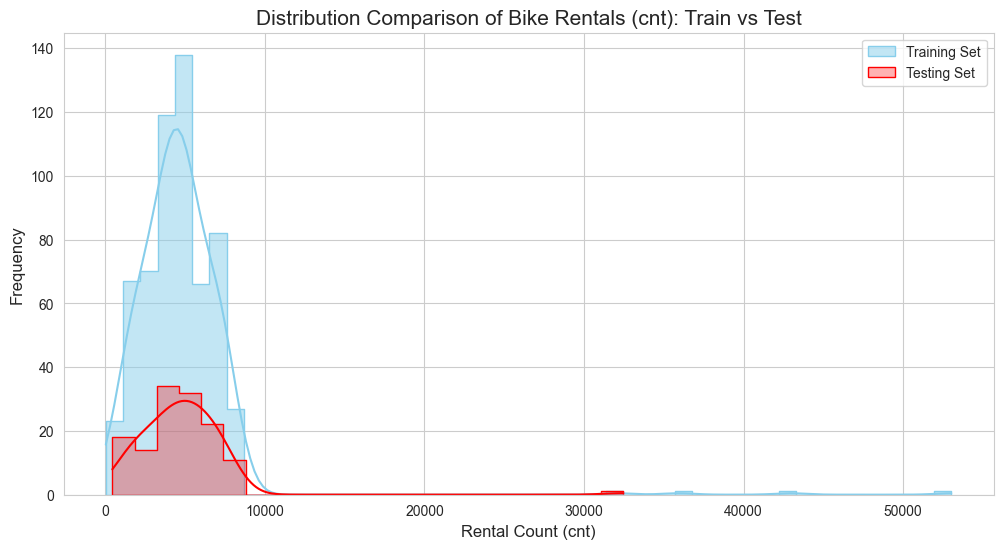

In [ ]:
# Set the visual style
sns.set_style("whitegrid")
# Create the figure
plt.figure(figsize=(12, 6))
# 1. Plot the Train distribution
sns.histplot(train_set['cnt'], kde=True, color="skyblue", label="Training Set", element="step")
# 2. Plot the Test distribution (using a different color and transparency)
sns.histplot(test_set['cnt'], kde=True, color="red", label="Testing Set", element="step", alpha=0.3)
# Add titles and labels
plt.title('Distribution Comparison of Bike Rentals (cnt): Train vs Test', fontsize=15)
plt.xlabel('Rental Count (cnt)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

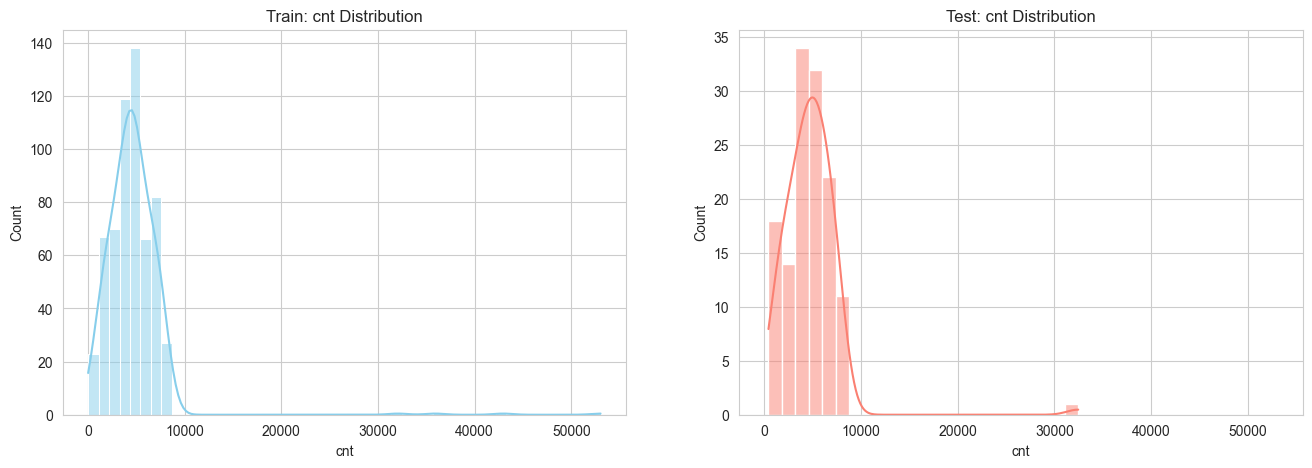

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)

sns.histplot(train_set['cnt'], kde=True, ax=axes[0], color='skyblue').set_title('Train: cnt Distribution')
sns.histplot(test_set['cnt'], kde=True, ax=axes[1], color='salmon').set_title('Test: cnt Distribution')

plt.show()

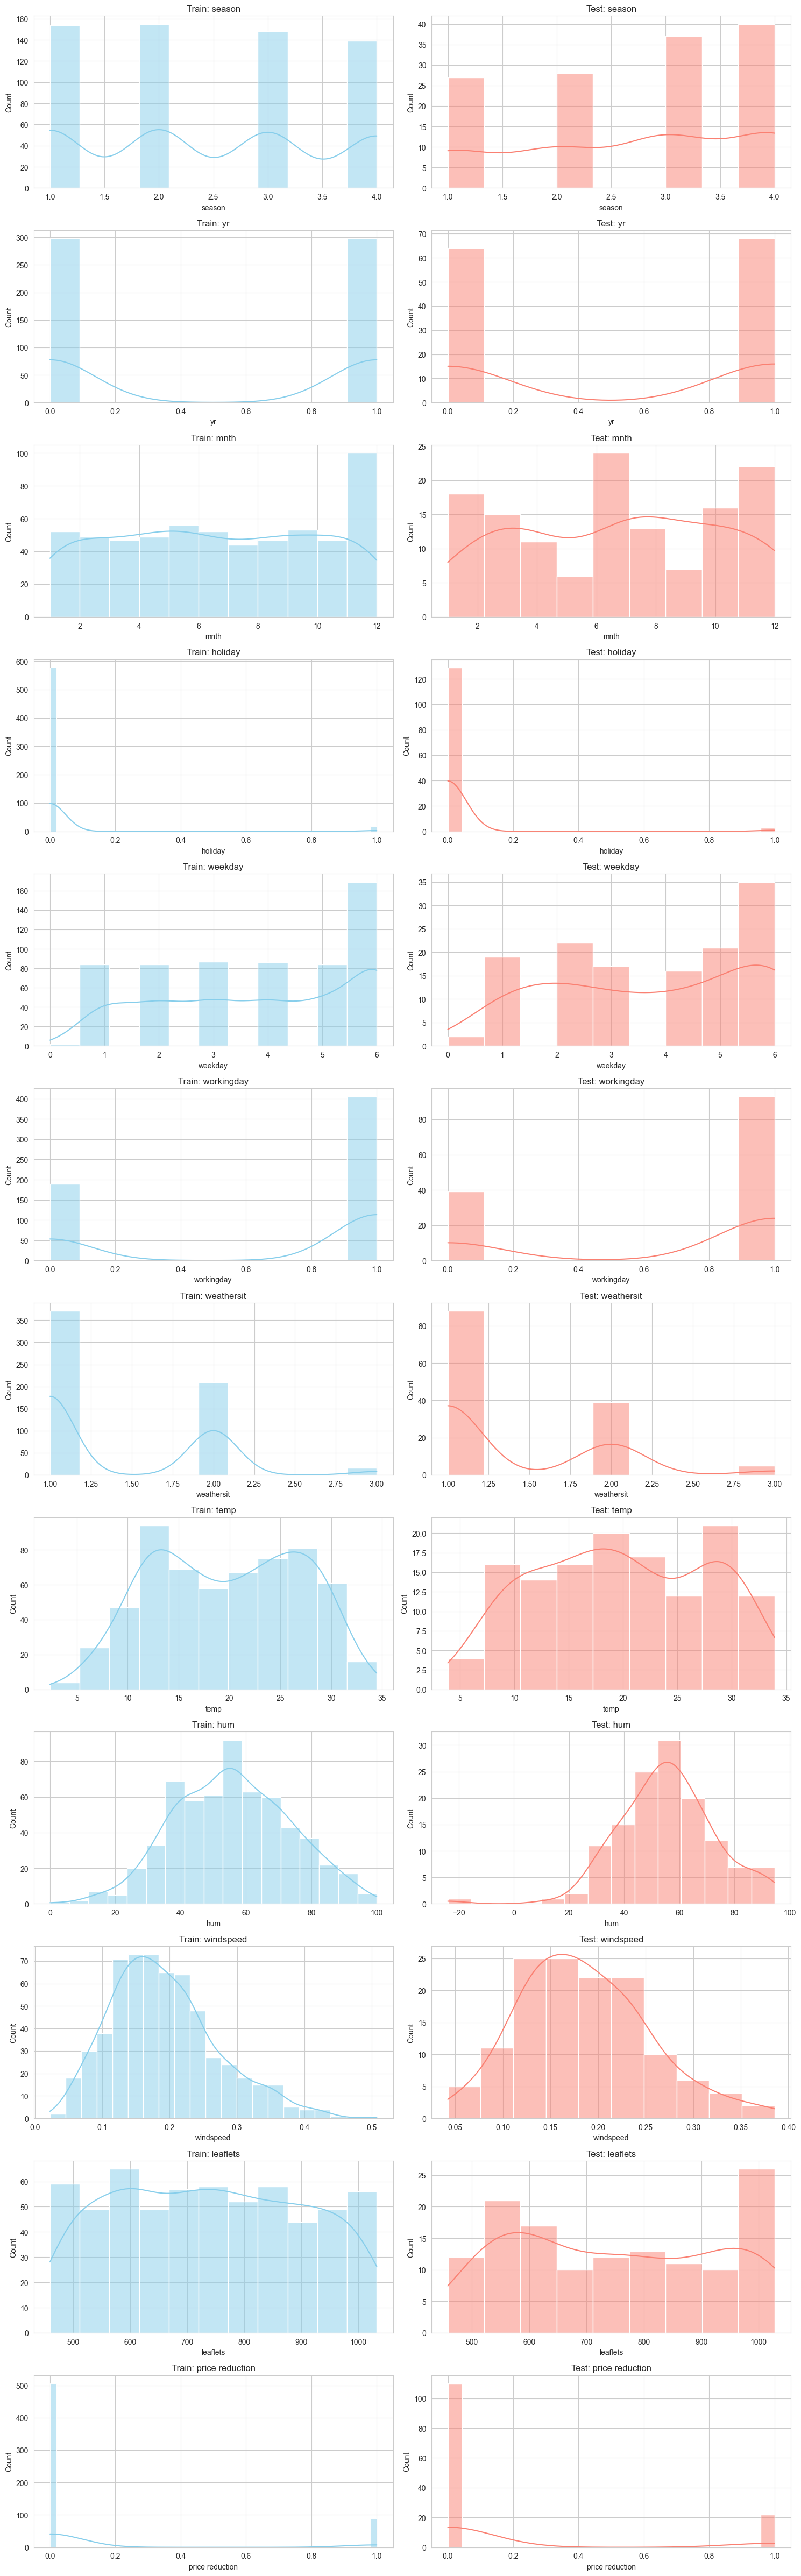

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Identify feature columns (everything except the target 'cnt')
features = [col for col in train_set.columns if col != 'cnt']
num_features = len(features)

# 2. Create a grid of subplots
# We create a 2-column layout (Train on Left, Test on Right) for every feature
fig, axes = plt.subplots(num_features, 2, figsize=(15, 4 * num_features))

for i, col in enumerate(features):
    # Plot Train distribution on the left
    sns.histplot(train_set[col], kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Train: {col}')
    
    # Plot Test distribution on the right
    sns.histplot(test_set[col], kde=True, ax=axes[i, 1], color='salmon')
    axes[i, 1].set_title(f'Test: {col}')

# Optimize space between plots
plt.tight_layout()
plt.show()